In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Mon Dec 28 23:39:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 52%   85C    P2   227W / 250W |   3533MiB / 11019MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 30%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 20

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '28December_Tracks_to_Hists"'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 3e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
##device = select_gpu(0)
device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

'''train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )
'''


                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(0,20)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 37.31 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20 event dataset took 0.03948 s
x_t.shape =  torch.Size([20, 9, 600])
x_t.shape[0] =  20
x_t.shape[1] =  9
x_t.shape =  torch.Size([20, 9, 600])
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 0.0147 s
PV.n.shape =     (20000,)
PV.n[0].shape =  6
PV.x[0] =        -0.06039733 0.034324445 0.032115813 0.0021888595 -0.035334907 -0.013019809
PV.y[0] =        -0.09381338 -0.013181885 -0.030898828 -0.08940365 -0.0058297813 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=1e-5, debug=True)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

## model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


for model_t2kde_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
index, k =   28    fc1.weight
index, k =   29    fc1.bias
index, k =   30    finalFil

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

val_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7efce326abd0>
outputs.shape =  torch.Size([16, 4000])
labels.shape =   torch.Size([16, 4000])
costs -  tensor(4.5832)
y.shape =  torch.Size([16, 4000, 1])
y_kde.shape =  (4000,)
event =  0


<IPython.core.display.Javascript object>


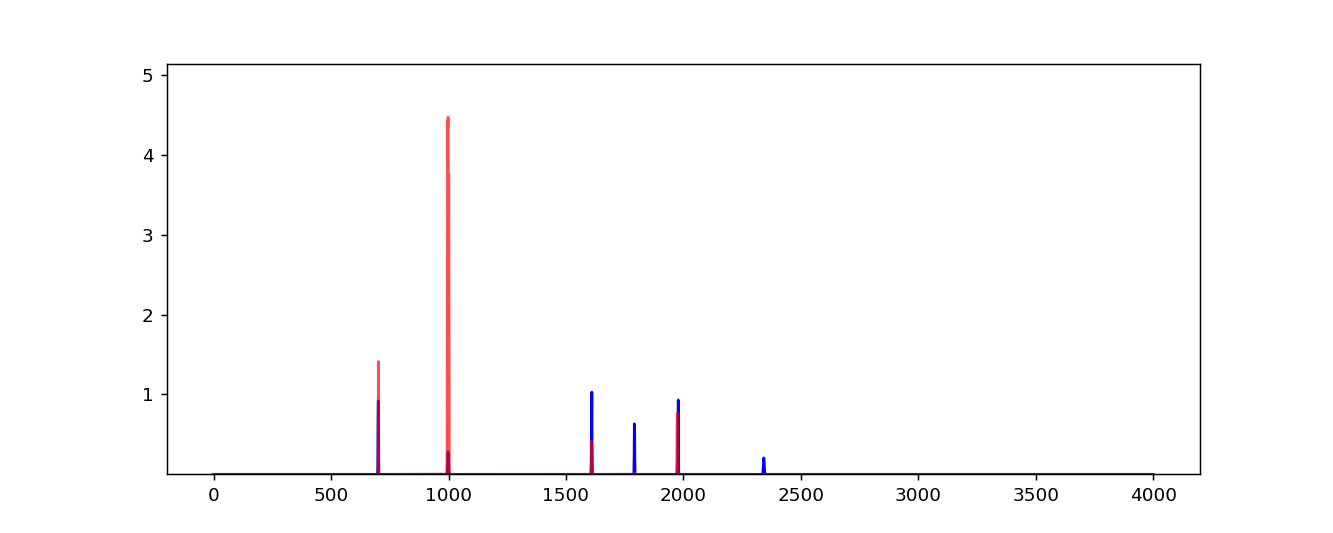

outputs.shape =  torch.Size([4, 4000])
labels.shape =   torch.Size([4, 4000])
costs -  tensor(0.6461)
y.shape =  torch.Size([4, 4000, 1])
y_kde.shape =  (4000,)
event =  1


<IPython.core.display.Javascript object>


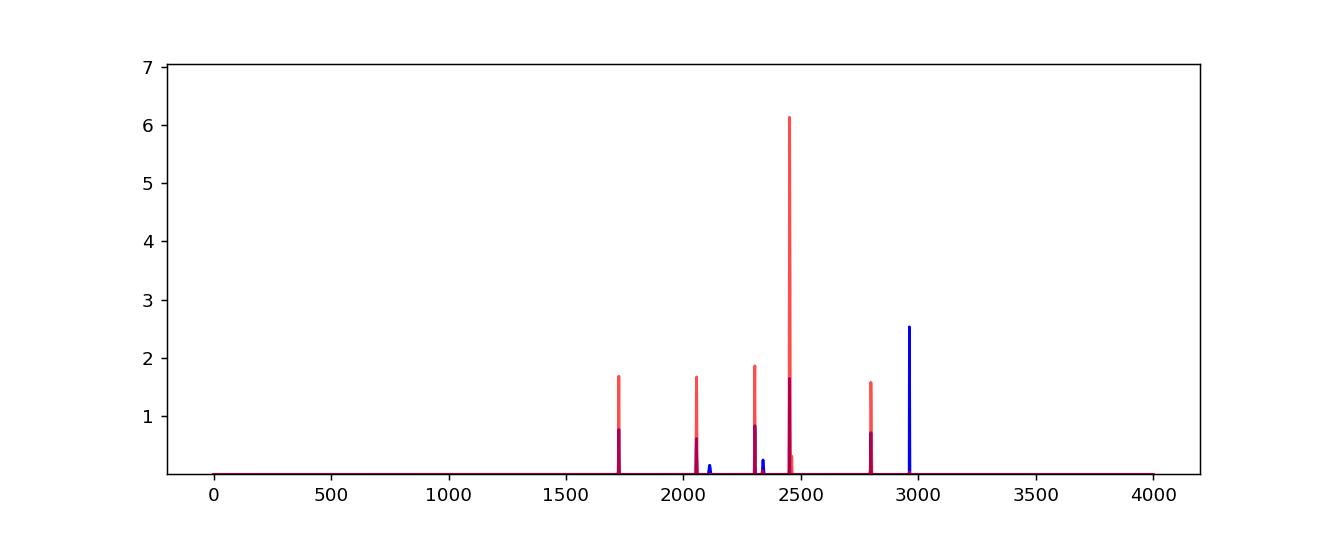

"           \n            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):\n                # Only print out if z in plotting range\n                if (event<11):\n                    print()\n                    print(f'PV: {n} tracks (type {cat})')\n                    print(f'  x: {x*1000:5.0f} μm')\n                    print(f'  y: {y*1000:5.0f} μm')\n                    print(f'  z: {z:8.3f} mm')\n"

In [14]:
with torch.no_grad():
    counter = 0
    event = 0
    print("val_loader = ",val_loader)
    for inputs, labels in val_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
## mds dec28        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        print("outputs.shape = ", outputs.shape)
        print("labels.shape =  ",labels.shape)
        
        costs = loss(outputs,labels)
        print("costs = ",costs)

    
    
        nFeatures = 4000
        y = labels.view(nEvts,-1,nFeatures)
        y = y.transpose(1,2)
        
       
        print("y.shape = ",y.shape)
        for iEvt in range(1):
            
            y_pred = outputs[iEvt,:]
        
            
            y_pred = y_pred.cpu().numpy()
            
            y_kde = y[iEvt,:,0].cpu().numpy()
            # Compute the "actual" efficenies and things
            print("y_kde.shape = ",y_kde.shape)
            
            
            print("event = ",event)
            if (event<5):
                plt.figure()
##                plt.yscale('log')
                plt.ylim(0.0005,1.15*max(y_pred))
                plt.plot(y_kde, color="b")
                plt.plot(y_pred, color='r', alpha = 0.7)
                plt.show()
            event = event +1
"""           
            for x,y,z,n,cat in zip(PV.x[event], PV.y[event], PV.z[event], PV.n[event], PV.cat[event]):
                # Only print out if z in plotting range
                if (event<11):
                    print()
                    print(f'PV: {n} tracks (type {cat})')
                    print(f'  x: {x*1000:5.0f} μm')
                    print(f'  y: {y*1000:5.0f} μm')
                    print(f'  z: {z:8.3f} mm')
"""




                
                
                
                
##                print("  point AA ")
## mds                features = inputs[iEvt,:]
## mds                features = features[np.newaxis,:,:]
                
                
## mds                print("features.shape = ",features.shape)
                
## mds                output_A = model(features)
## mds                y_prime = output_A[0,:]
## mds                y_prime = y_prime.cpu().numpy()
## mds                plt.figure()
## mds                plt.plot(y_prime[:], color="r")
## mds                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
##        counter = counter+1
        
        
        

val_loader =  <torch.utils.data.dataloader.DataLoader object at 0x7efce326abd0>
outputs.shape =  torch.Size([20, 4000])
 =  tensor([[1.9978e-09, 1.7566e-09, 2.3514e-09,  ..., 1.8266e-09, 2.5002e-09,
         1.8263e-09],
        [1.9460e-08, 1.8216e-08, 1.9595e-08,  ..., 2.0207e-08, 1.8940e-08,
         1.9211e-08],
        [1.2512e-08, 1.1912e-08, 1.3121e-08,  ..., 1.3150e-08, 1.2671e-08,
         1.1604e-08],
        ...,
        [1.5703e-09, 1.4712e-09, 1.9090e-09,  ..., 1.4860e-09, 1.6494e-09,
         1.5266e-09],
        [2.3315e-09, 2.0942e-09, 1.8594e-09,  ..., 1.9134e-09, 1.9423e-09,
         1.5926e-09],
        [1.6349e-09, 1.4046e-09, 1.5568e-09,  ..., 1.5038e-09, 1.4955e-09,
         1.4249e-09]])
nEvts =  20
y.shape =  torch.Size([20, 4000, 1])
iEvt =  0
good_pvs =  [(-29.881668, 1, 24), (-0.15807877, 1, 10), (61.021088, 1, 26), (79.19783, 1, 19), (97.82085, 1, 24), (134.26784, 1, 7)]
good_pv_bins =  [701.0, 998.0, 1610.0, 1791.0, 1978.0, 2342.0]


<IPython.core.display.Javascript object>


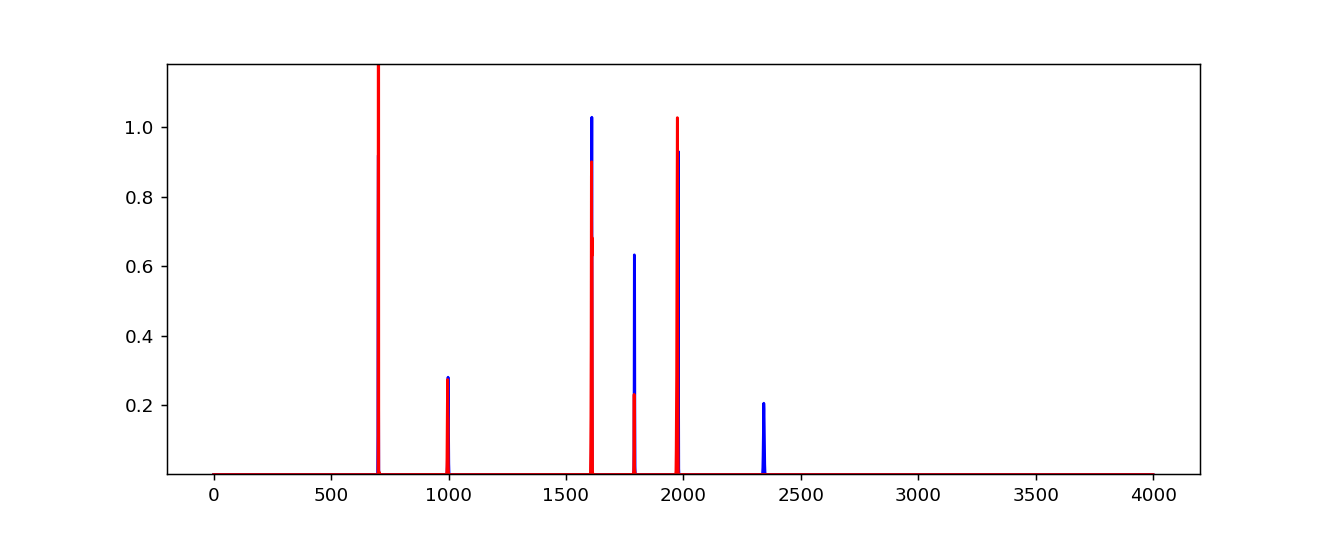

PV position and bin # =  (-29.881668, 1, 24) 701.0


<IPython.core.display.Javascript object>


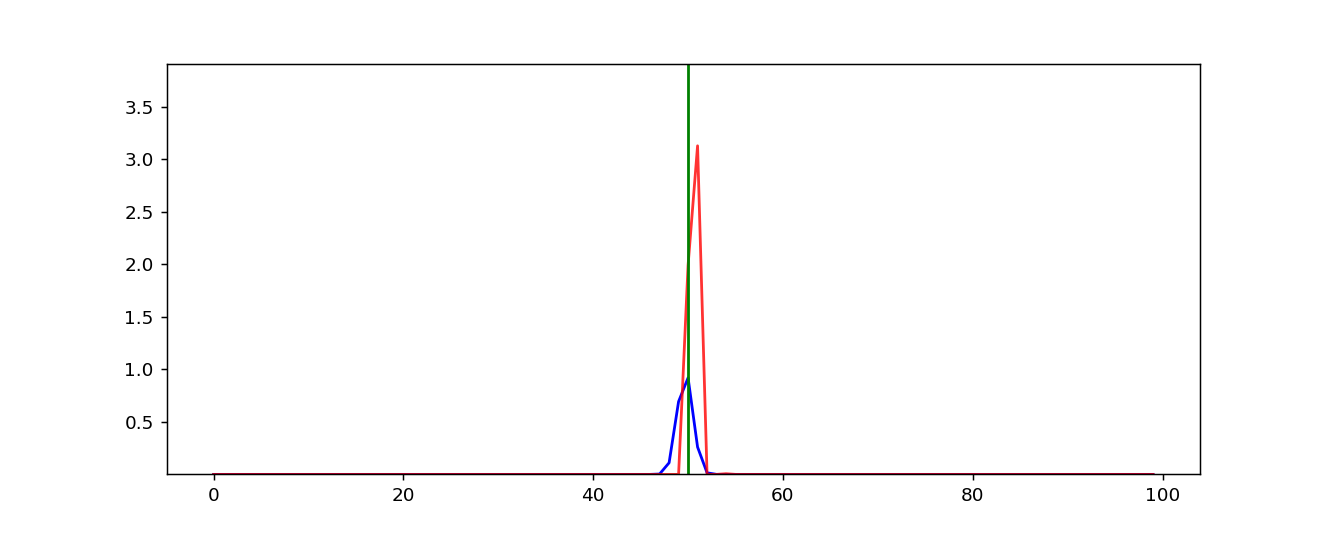

PV position and bin # =  (-0.15807877, 1, 10) 998.0


<IPython.core.display.Javascript object>


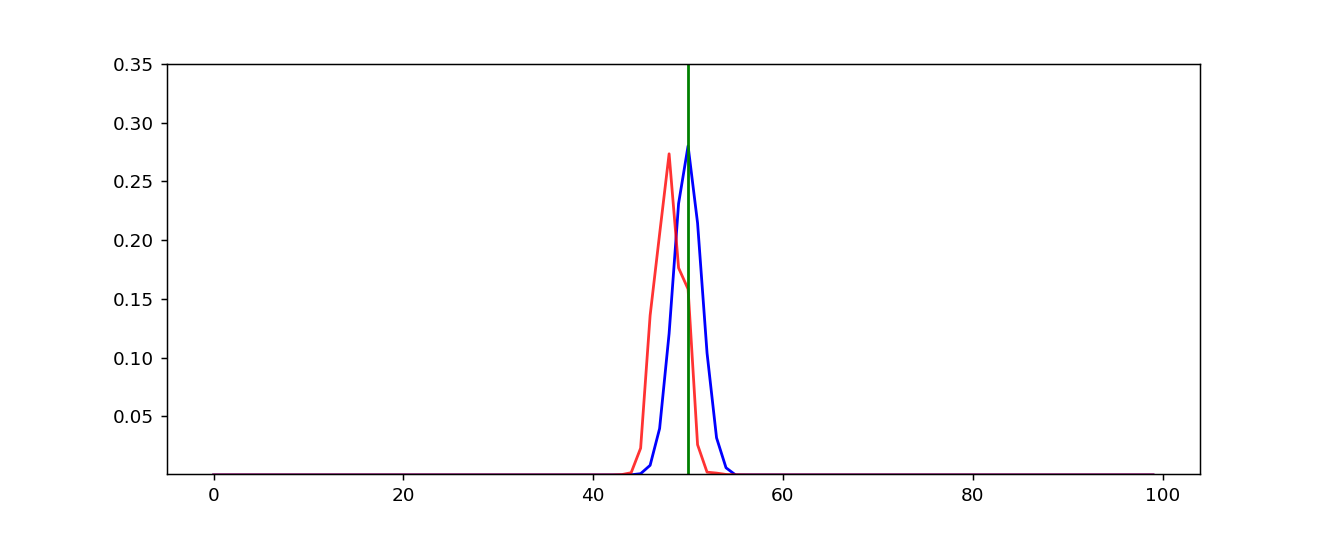

PV position and bin # =  (61.021088, 1, 26) 1610.0


<IPython.core.display.Javascript object>


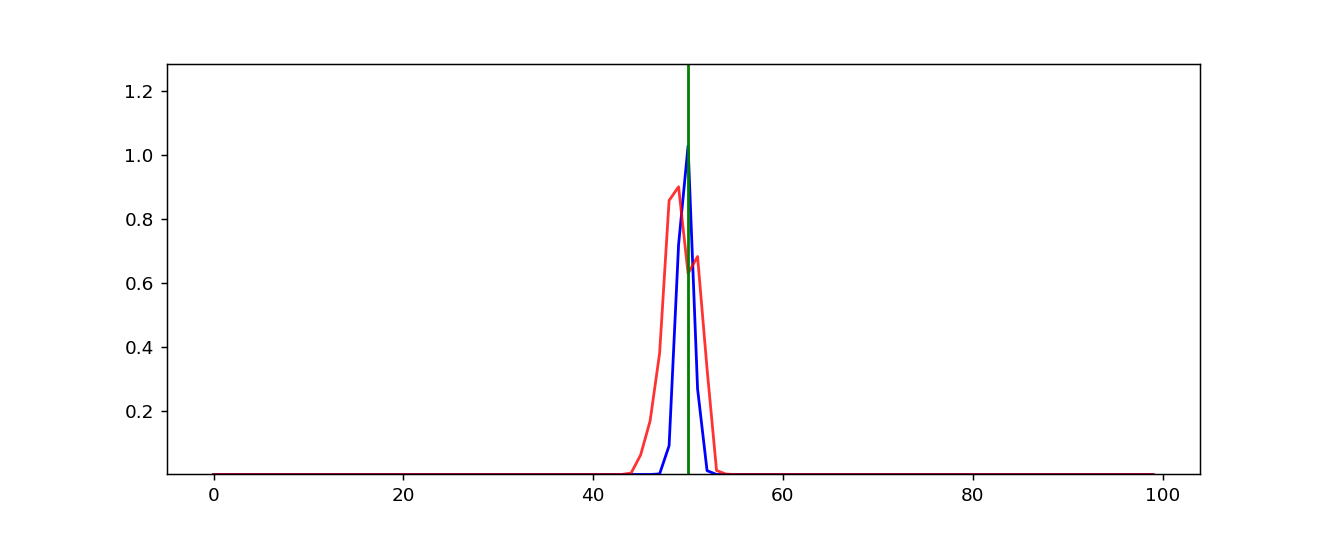

PV position and bin # =  (79.19783, 1, 19) 1791.0


<IPython.core.display.Javascript object>


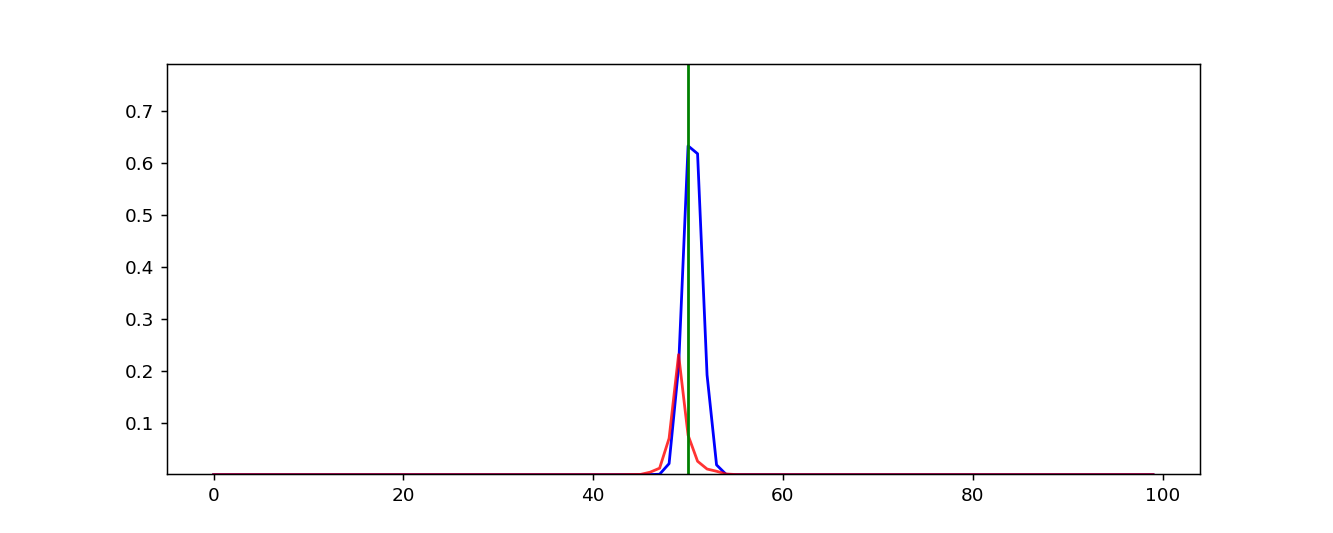

PV position and bin # =  (97.82085, 1, 24) 1978.0


<IPython.core.display.Javascript object>


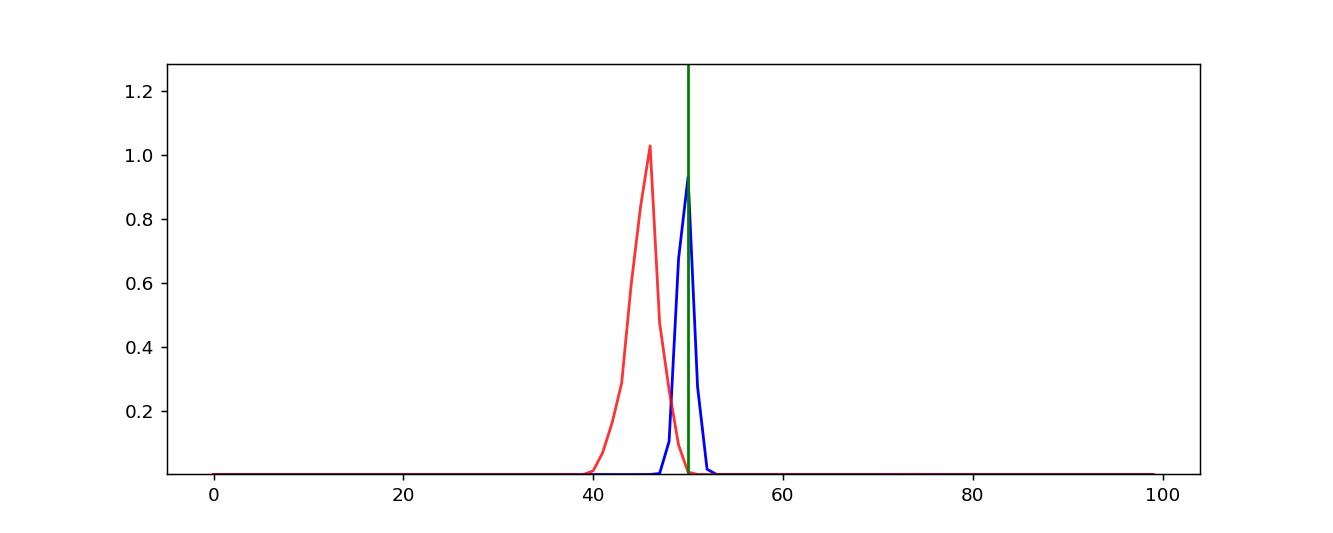

PV position and bin # =  (134.26784, 1, 7) 2342.0


<IPython.core.display.Javascript object>


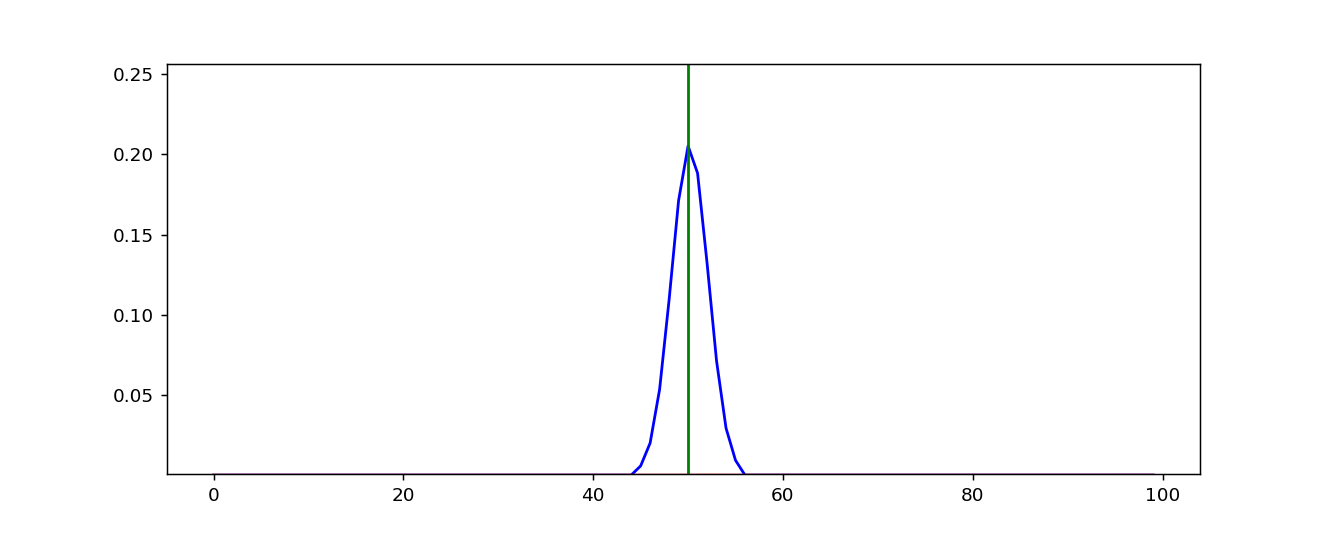

iEvt =  1
good_pvs =  [(119.57261, 1, 7)]
good_pv_bins =  [2195.0]


<IPython.core.display.Javascript object>


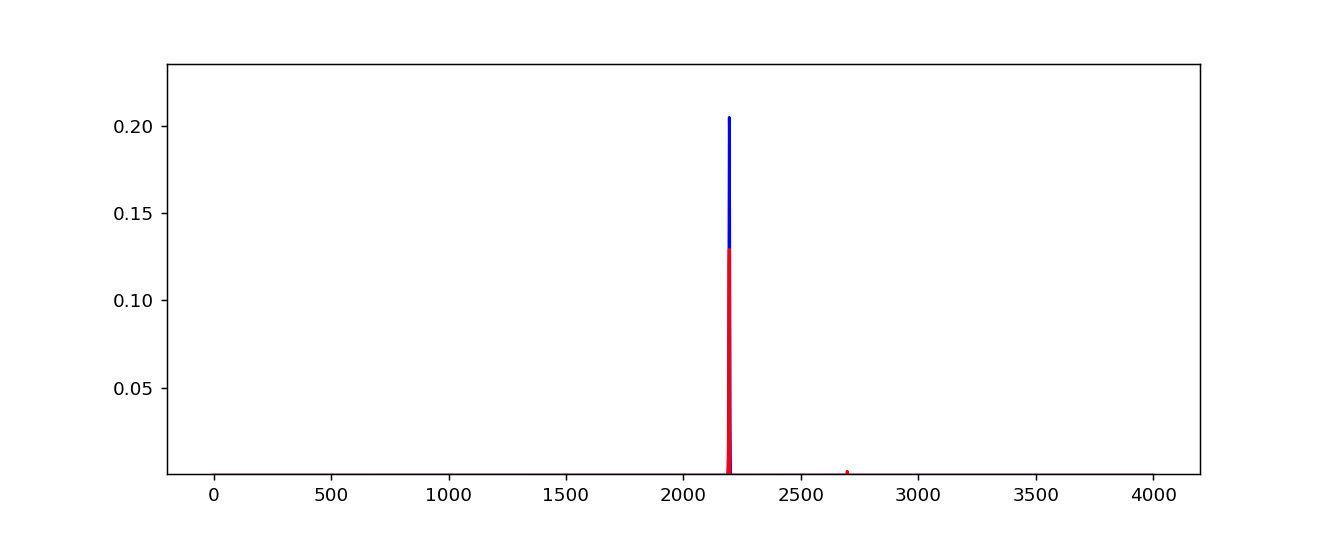

PV position and bin # =  (119.57261, 1, 7) 2195.0


<IPython.core.display.Javascript object>


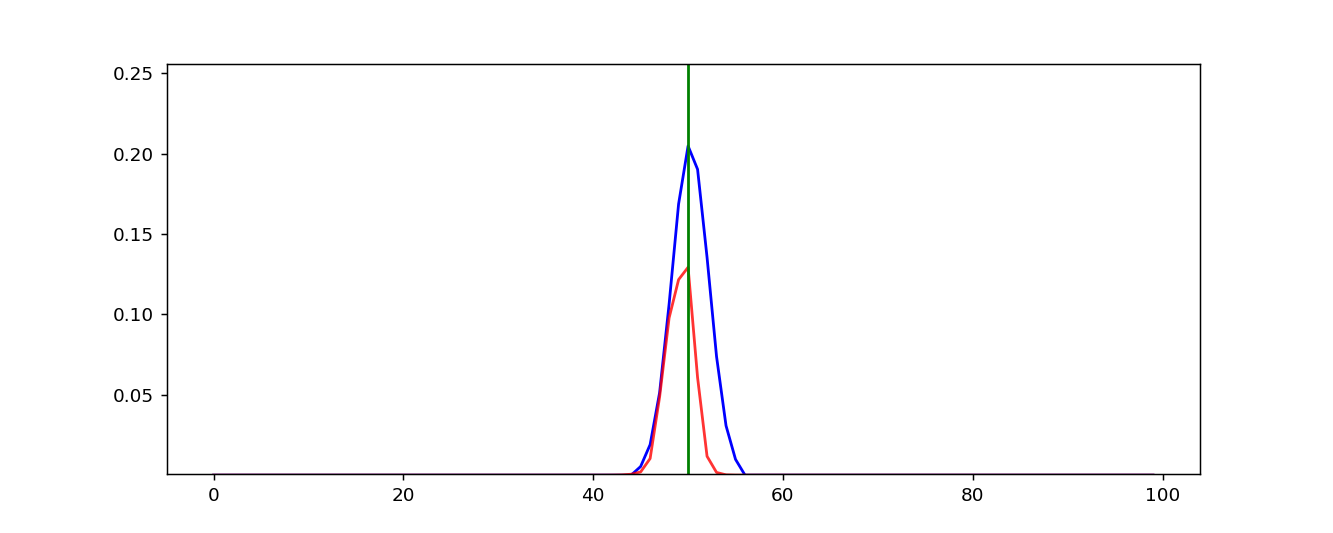

iEvt =  2
good_pvs =  [(116.2301, 1, 5), (137.23302, 1, 7)]
good_pv_bins =  [2162.0, 2372.0]


<IPython.core.display.Javascript object>


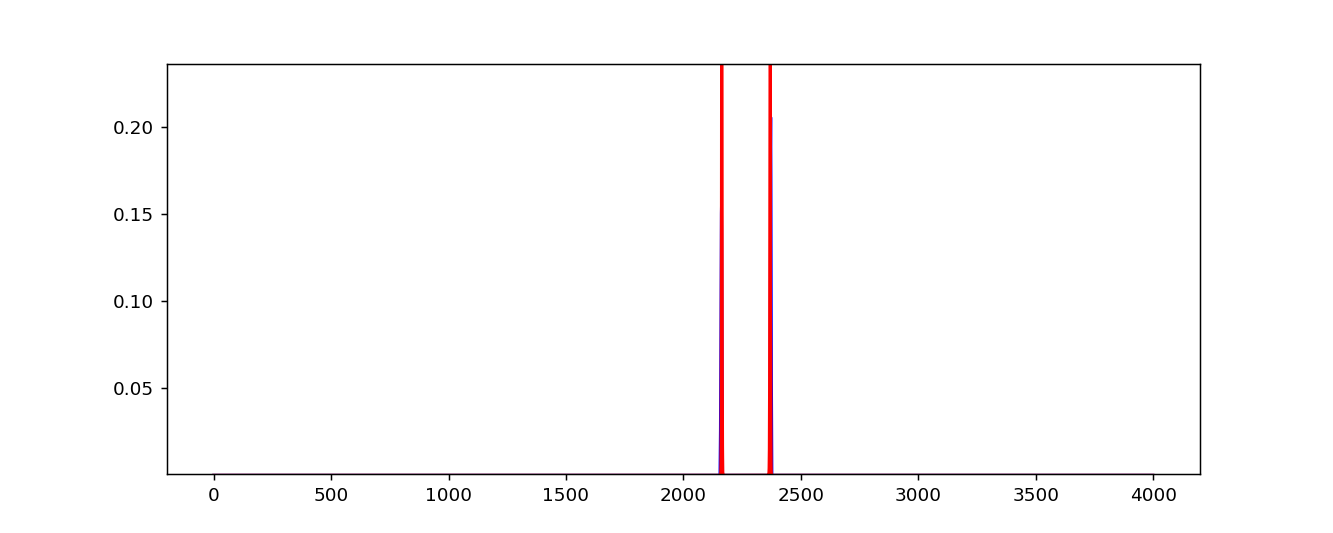

PV position and bin # =  (116.2301, 1, 5) 2162.0


<IPython.core.display.Javascript object>


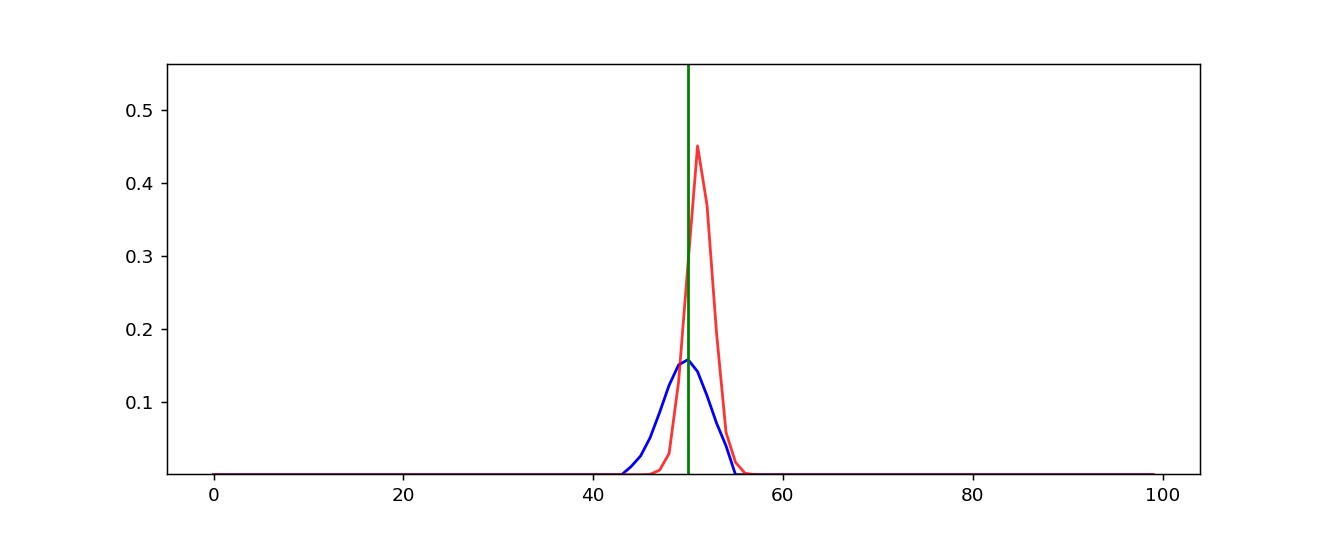

PV position and bin # =  (137.23302, 1, 7) 2372.0


<IPython.core.display.Javascript object>


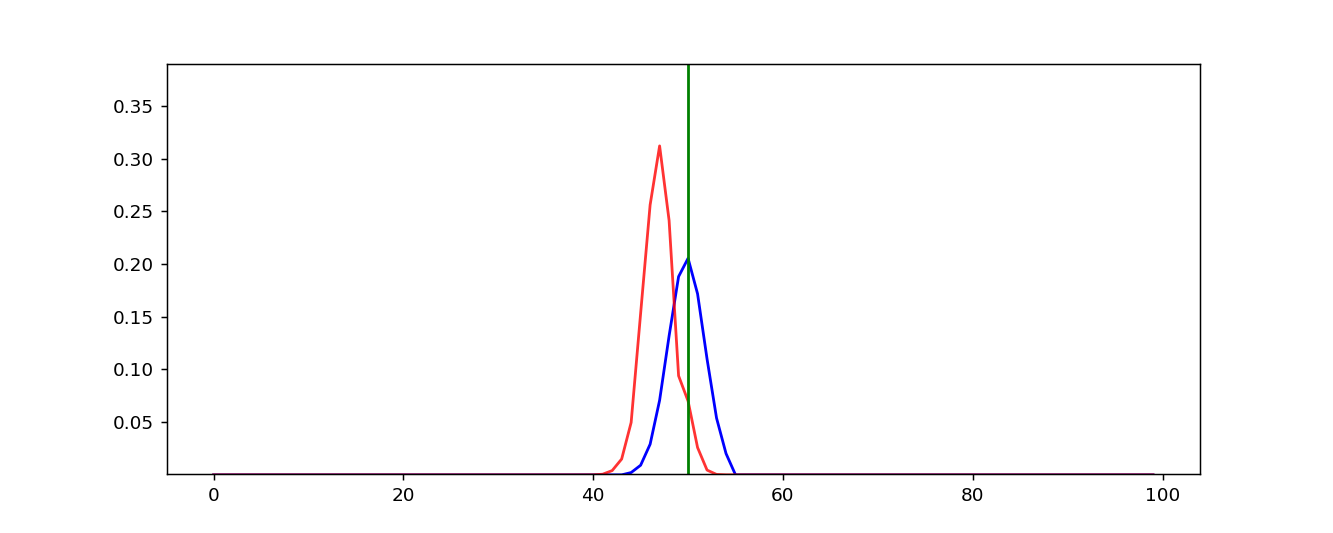

iEvt =  3
good_pvs =  [(-9.917648, 1, 25), (63.546913, 1, 28), (85.381065, 1, 13), (156.8066, 1, 42), (239.98242, 1, 11)]
good_pv_bins =  [900.0, 1635.0, 1853.0, 2568.0, 3399.0]


<IPython.core.display.Javascript object>


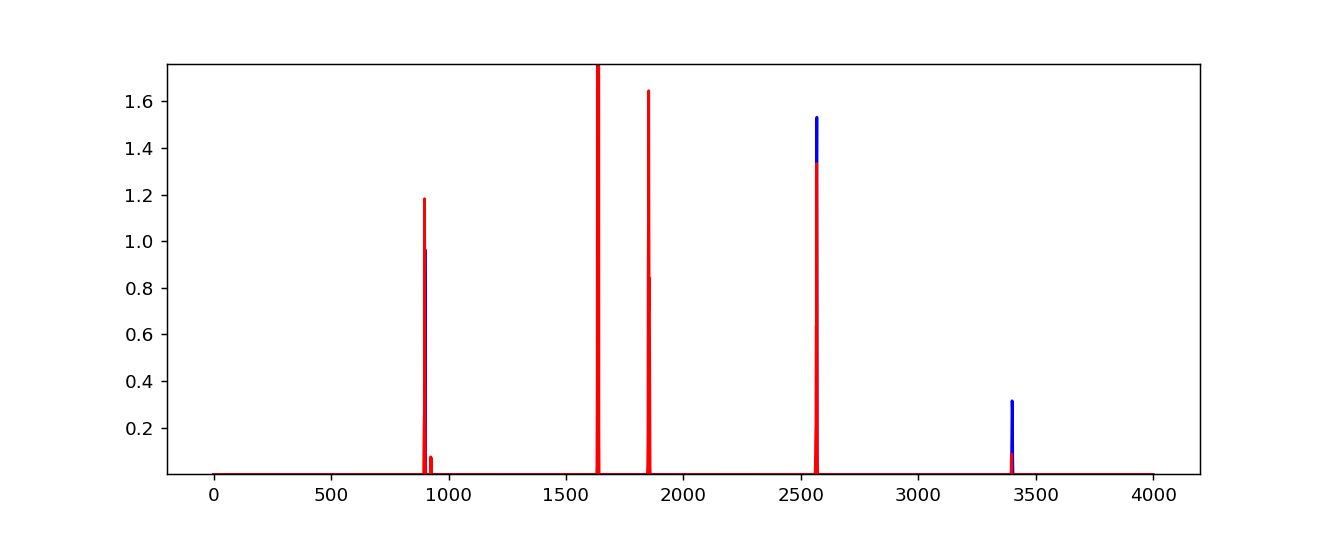

PV position and bin # =  (-9.917648, 1, 25) 900.0


<IPython.core.display.Javascript object>


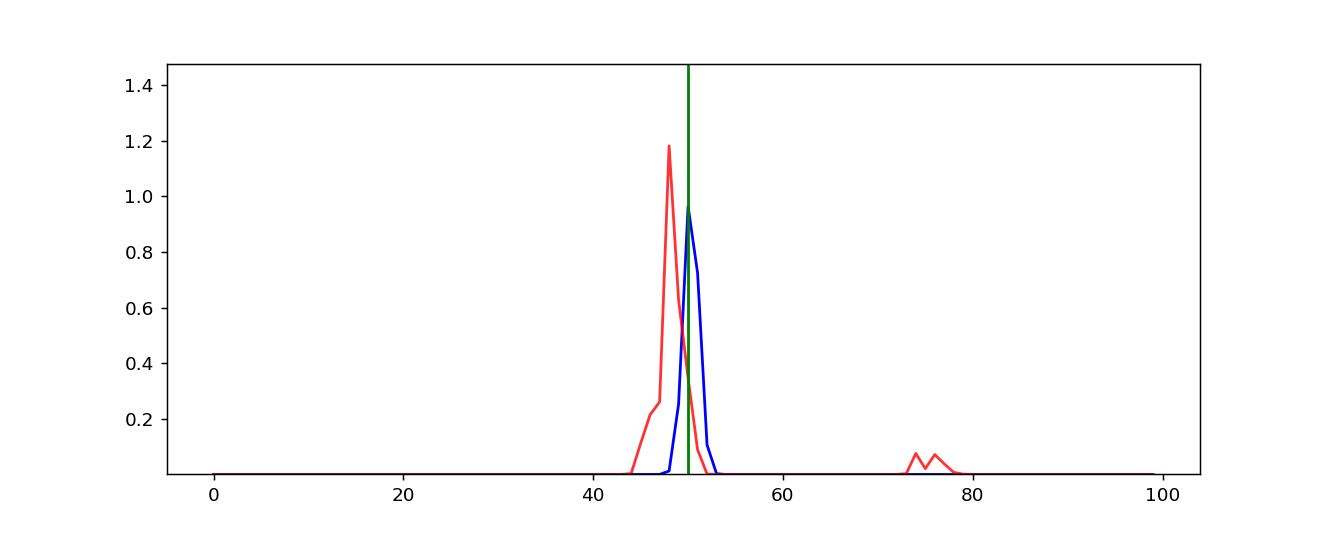

PV position and bin # =  (63.546913, 1, 28) 1635.0


<IPython.core.display.Javascript object>


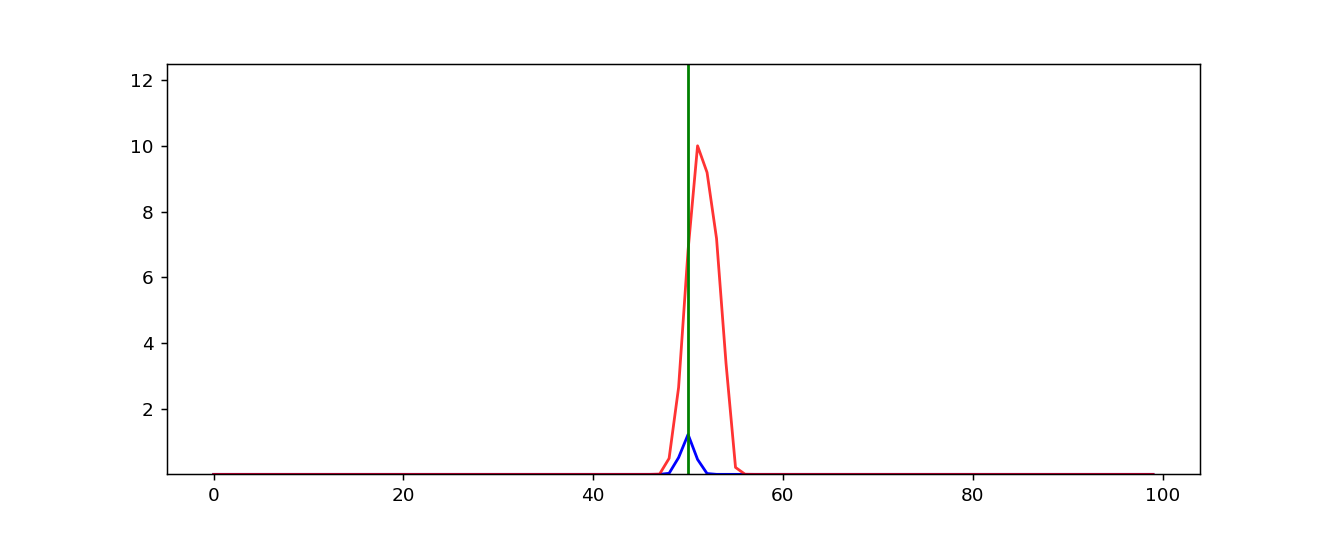

PV position and bin # =  (85.381065, 1, 13) 1853.0


<IPython.core.display.Javascript object>


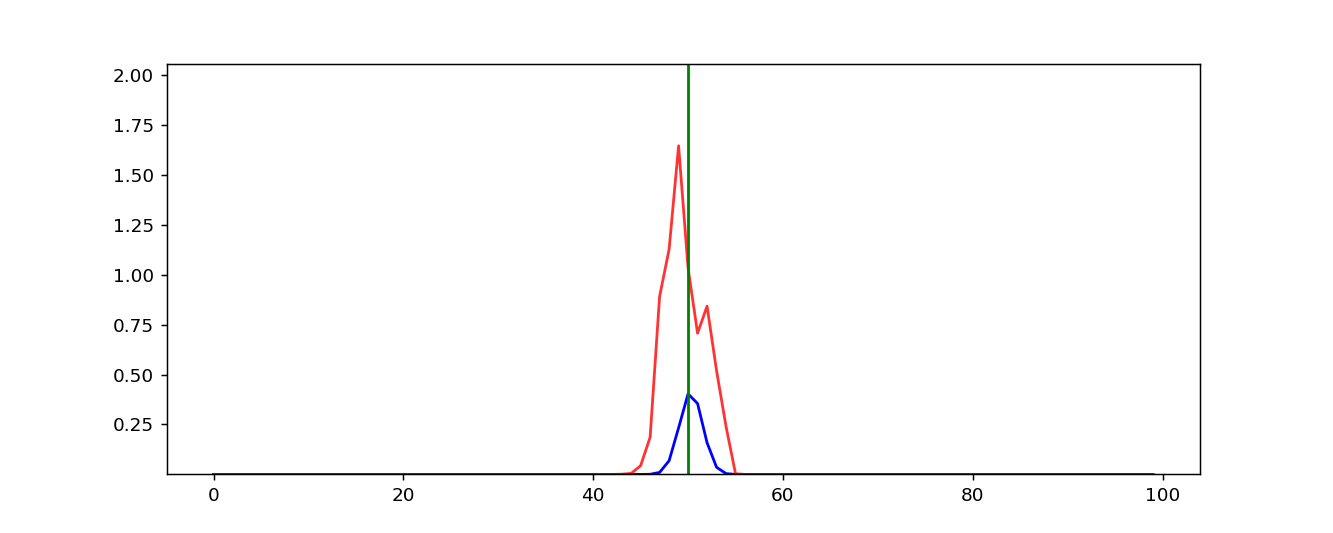

PV position and bin # =  (156.8066, 1, 42) 2568.0


<IPython.core.display.Javascript object>


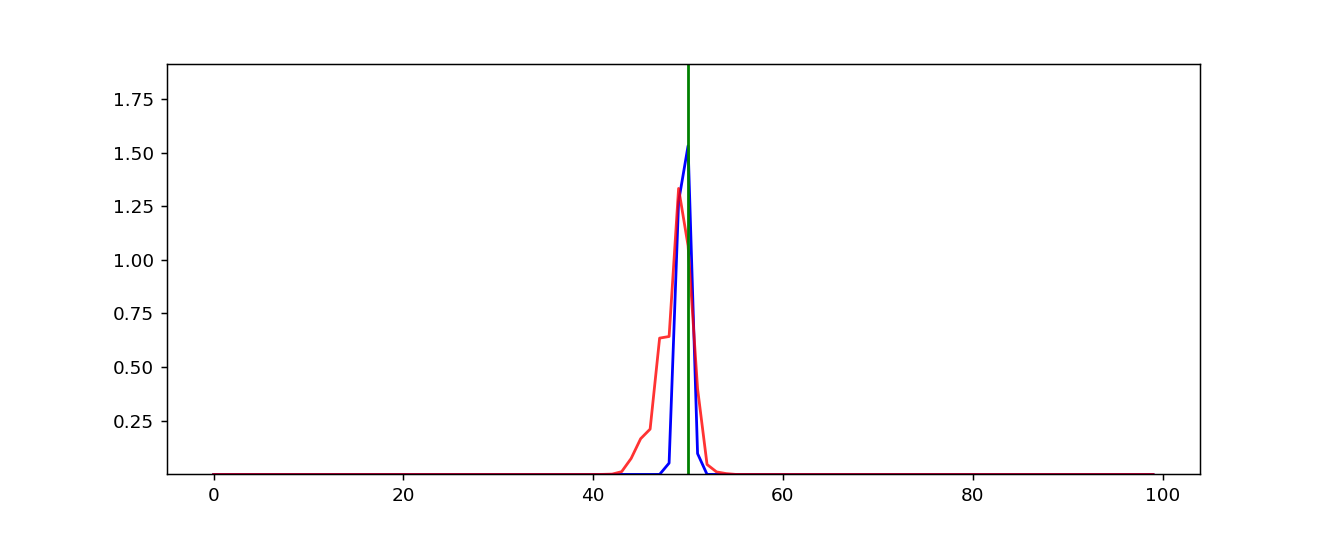

PV position and bin # =  (239.98242, 1, 11) 3399.0


<IPython.core.display.Javascript object>


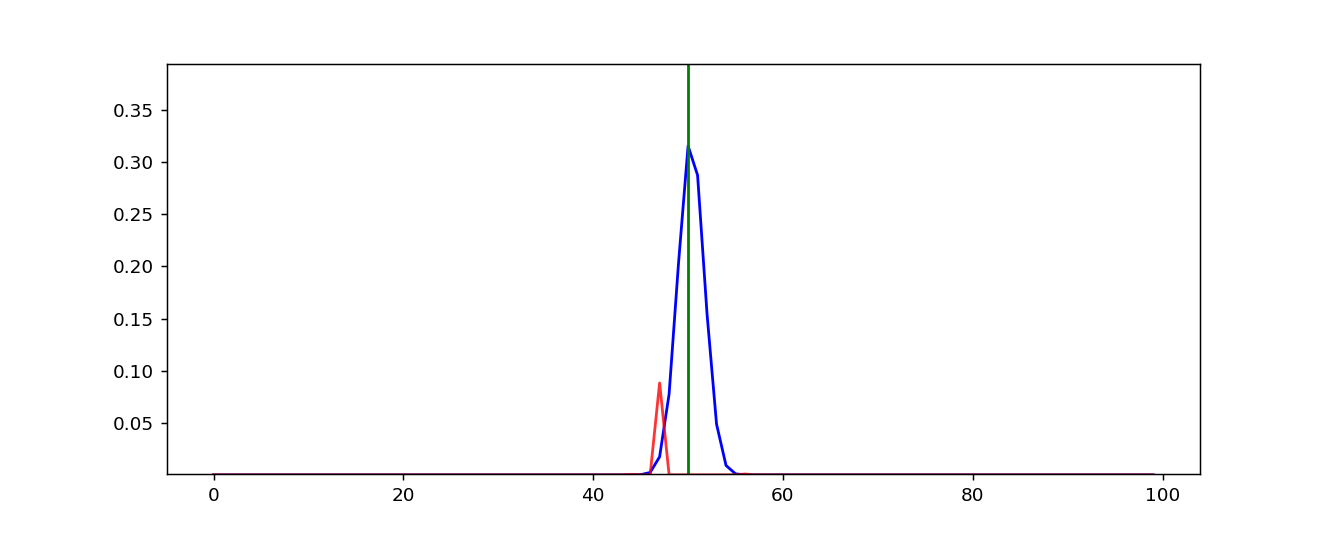

iEvt =  4
good_pvs =  [(26.315554, 1, 7), (85.32848, 1, 17), (132.24886, 1, 7), (151.79068, 1, 22), (186.51968, 1, 24), (262.89627, 1, 23)]
good_pv_bins =  [1263.0, 1853.0, 2322.0, 2517.0, 2865.0, 3628.0]


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


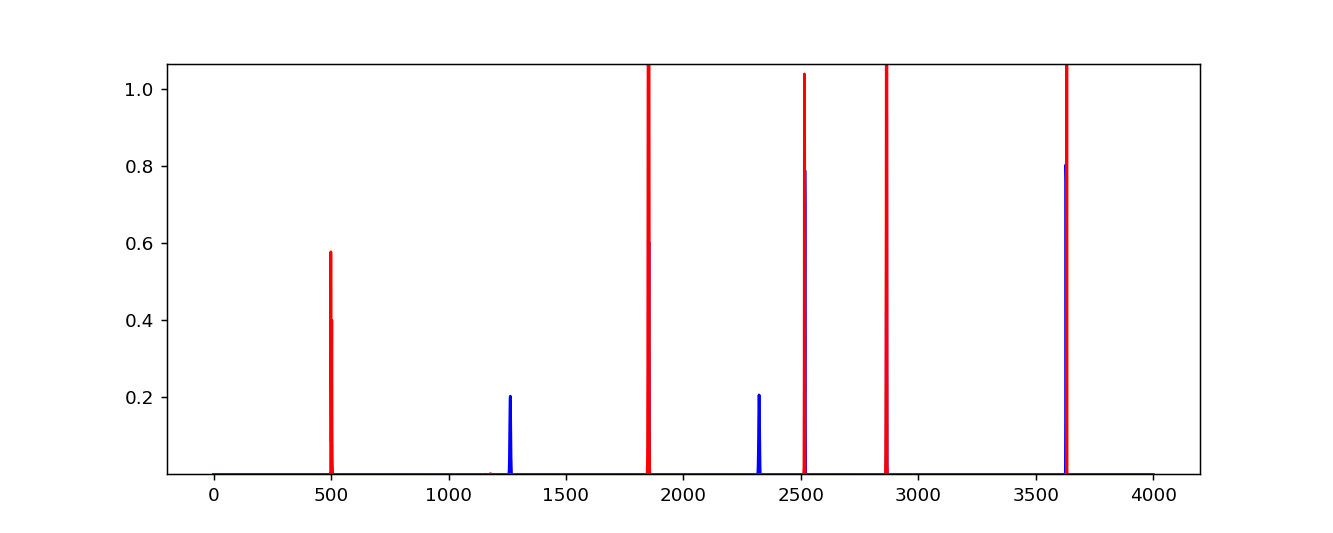

PV position and bin # =  (26.315554, 1, 7) 1263.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


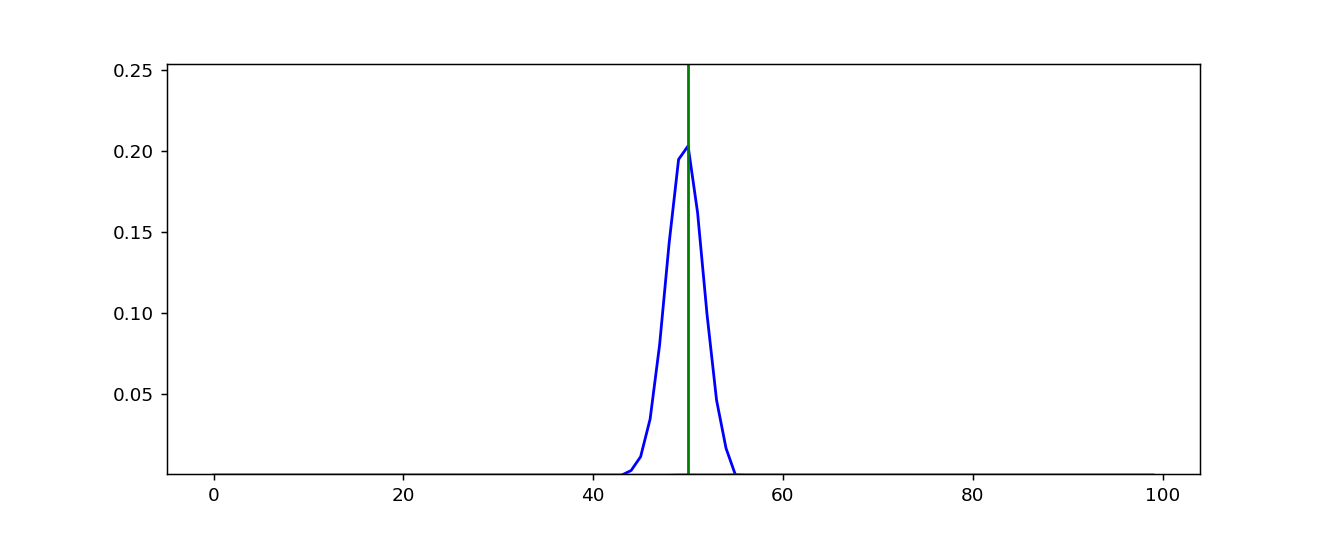

PV position and bin # =  (85.32848, 1, 17) 1853.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


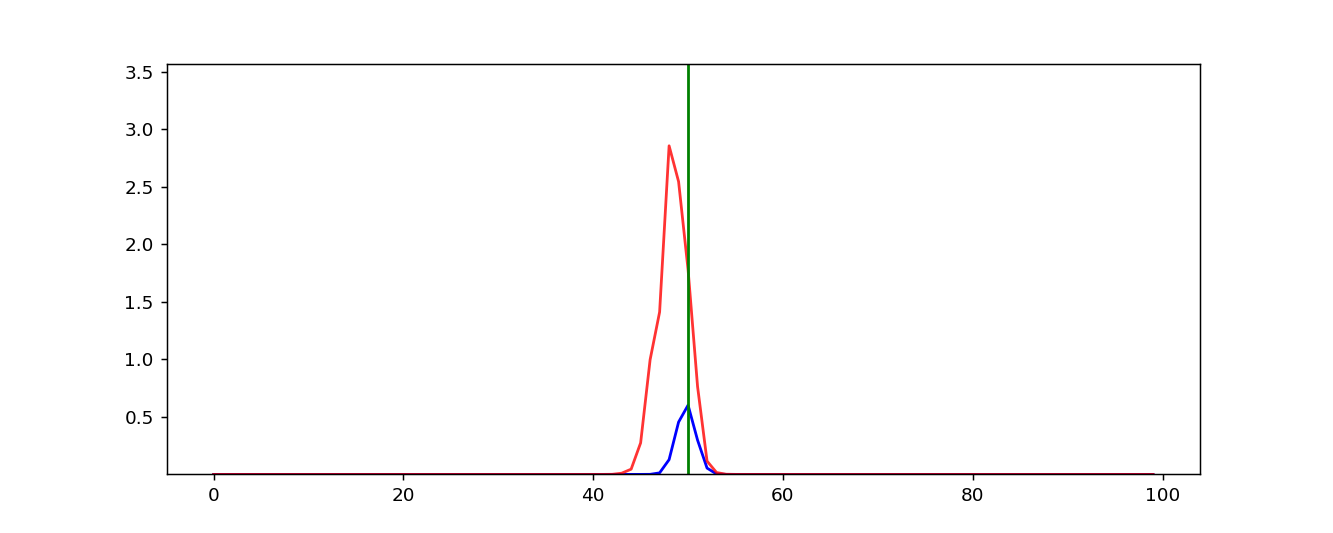

PV position and bin # =  (132.24886, 1, 7) 2322.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


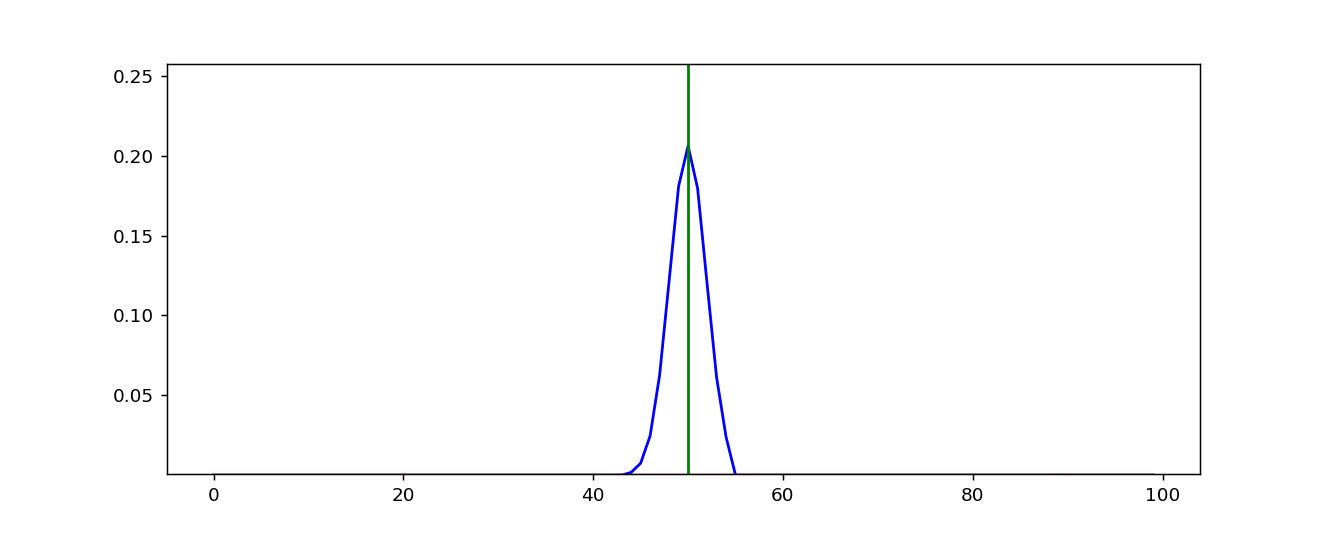

PV position and bin # =  (151.79068, 1, 22) 2517.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


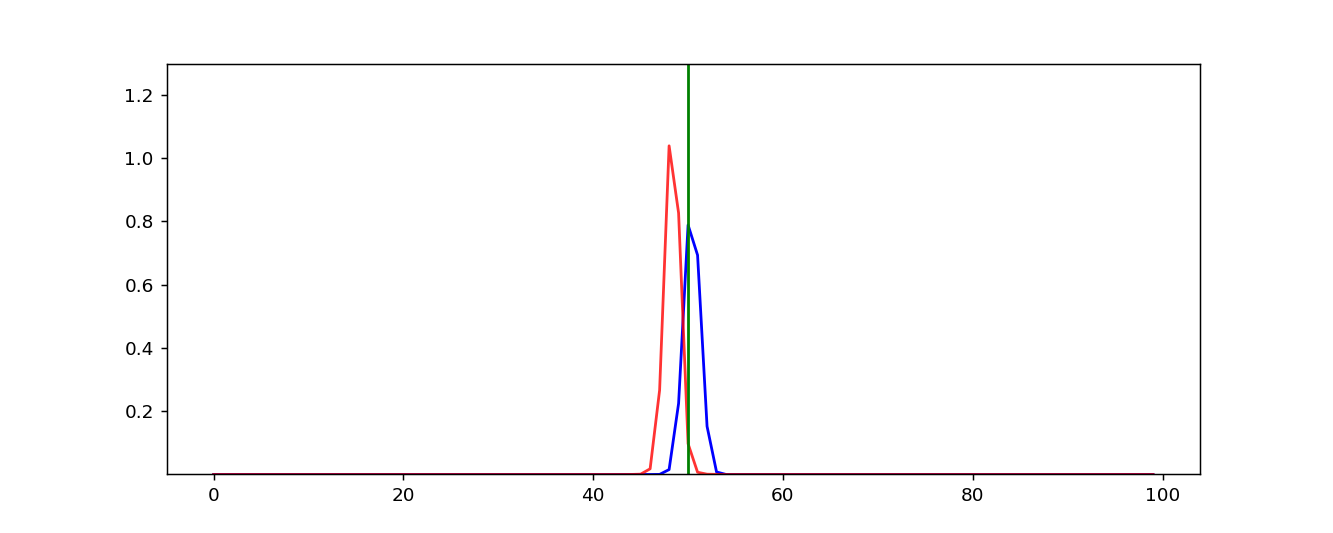

PV position and bin # =  (186.51968, 1, 24) 2865.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


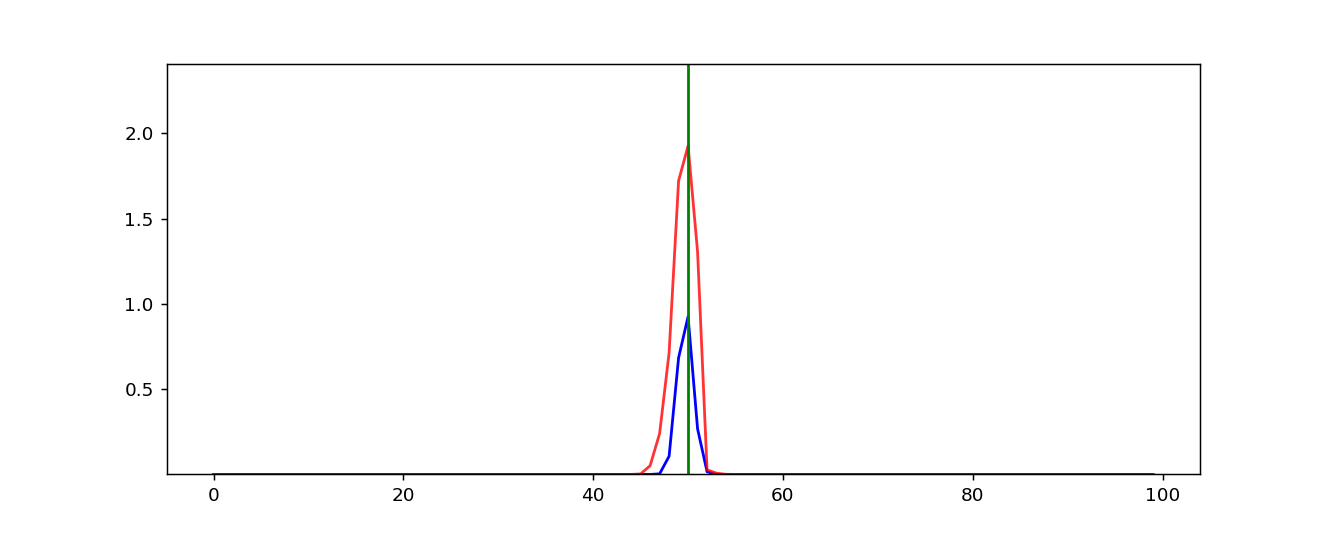

PV position and bin # =  (262.89627, 1, 23) 3628.0


/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


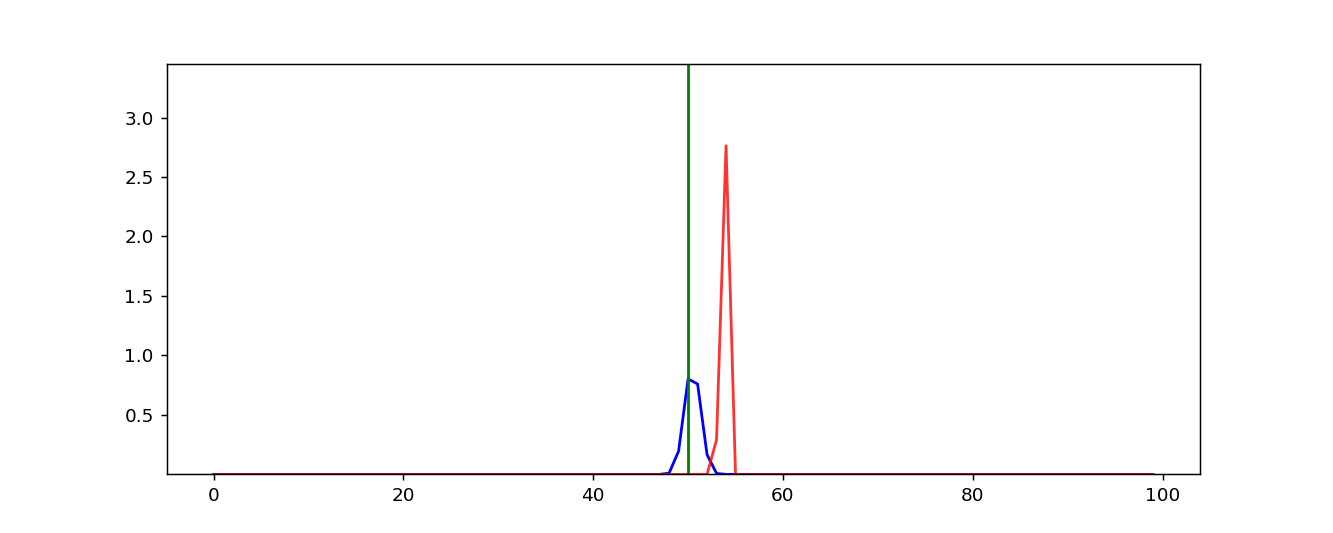

In [15]:
nFeatures = 4000
with torch.no_grad():
    print("val_loader = ",val_loader)
    outputs = model(val_loader.dataset.tensors[0])
    print("outputs.shape = ",outputs.shape)
    print(' = ',outputs)
    nEvts = outputs.shape[0]
    print("nEvts = ",nEvts)
    labels = val_loader.dataset.tensors[1]
    y = labels.view(nEvts,-1,nFeatures)
    y = y.transpose(1,2)
    print("y.shape = ",y.shape)
    
    
##    for iEvt in range(nEvts):
    for iEvt in range(5):
        print("iEvt = ",iEvt)
        y_kde = y[iEvt,:,0].cpu().numpy()
##        print("len(y_kde) = ",len(y_kde))
        
        y_pred = outputs[iEvt,:].cpu().numpy()
##        print("len(y_pred) = ",len(y_pred))
        
##        print("PV.z[iEvt]   = ", PV.z[iEvt])
##        print("PV.cat[iEvt] = ", PV.cat[iEvt])
##        print("PV.n[iEvt]   = ", PV.n[iEvt])
        
        pv_sorted = sorted(zip(PV.z[iEvt],PV.cat[iEvt],PV.n[iEvt]), key=lambda x: x[0])
##        print("pv_sorted = ",pv_sorted)
##        print("len(pv_sorted) = ",len(pv_sorted))
        good_pvs = []
        good_pv_bins = []
        for ii in range(len(pv_sorted)):
##            print("ii = ",ii)
##            print(pv_sorted[ii])
##            print(pv_sorted[ii][1])
            good = (1 == pv_sorted[ii][1])
##            print("good = ",good)
            if (good):
                good_pvs.append(pv_sorted[ii])
                good_pv_bins.append(np.floor(10.*(pv_sorted[ii][0]+100)))
        print("good_pvs = ",good_pvs)
        print("good_pv_bins = ", good_pv_bins)
        
      
        
        plt.figure()
##      plt.yscale('log')
        plt.ylim(0.0005,1.15*max(y_kde))
        plt.plot(y_kde, color="b")
        plt.plot(y_pred, color='r')
        plt.show()

   

     
        nPlots = len(good_pv_bins)
        for jj in range(nPlots):
            print("PV position and bin # = ", good_pvs[jj], good_pv_bins[jj])
            nLow =  int(good_pv_bins[jj]-50)
            nHigh = int(good_pv_bins[jj]+50)
            plt.figure()
            max1 = max(y_kde[nLow:nHigh])
            max2 = max(y_pred[nLow:nHigh])
            ymax = max(max1,max2)
            plt.ylim(0.0005,1.25*ymax)
##            plt.yscale('log')
            plt.plot(y_kde[nLow:nHigh], color="b")
            plt.plot(y_pred[nLow:nHigh], color='r', alpha = 0.8)
            plt.axvline(x=50, color='g')
            plt.show()
          

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [16]:
##quit()

